In [35]:
import os
import glob 
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

from duke_dbt_data import dcmread_image, read_boxes, draw_box 

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [36]:
path_to_data = "/scratch/ojomoleye/dukedata/"
training_groups =  path_to_data + "trainingset_clingroups.csv"
training_files = path_to_data + "trainingset_paths_studies_views.csv"
training_boxes = path_to_data + "trainingset_boundingboxes.csv"
validation_files = path_to_data + "validationset_pats_studies_views.csv"
test_files = path_to_data + "testset_pats_studies_views.csv"

traingroups = pd.read_csv(training_groups)
trainfiles = pd.read_csv(training_files)
valfiles = pd.read_csv(validation_files)
testfiles = pd.read_csv(test_files)
trainbox = pd.read_csv(training_boxes)

In [37]:
test_files

'/scratch/ojomoleye/dukedata/testset_pats_studies_views.csv'

In [38]:
# point to real paths
trainfiles['real_path'] = trainfiles.classic_path.str.split(
    "/").str[1:4].apply(
    lambda x: path_to_data + "/".join(x) + "/*.dcm")

valfiles['real_path'] = valfiles.classic_path.str.split(
    "/").str[1:4].apply(
    lambda x: path_to_data + "/".join(x) + "/*.dcm")

test_files = testfiles.classic_path.str.split(
    "/").str[1:4].apply(
    lambda x: path_to_data + "/".join(x) + "/*.dcm")

In [39]:
def find_file(file_path):
    file_list = glob.glob(file_path)
    if len(file_list) == 0:
        return "No file found"
    elif len(file_list) > 1:
        return "{} files found".format(len(file_list))
    else:
        return file_list[0]

In [40]:
trainfiles['file_path'] = trainfiles["real_path"].apply(find_file)

In [41]:
trainfiles.file_path.nunique() == len(trainfiles) # only one file in the final sub-folder if True

True

In [42]:
new_trainfile_path = path_to_data + "trainingset_paths_studies_views_updated.csv"
trainfiles.to_csv(new_trainfile_path)

In [43]:
view_series = trainfiles.iloc[0]
view_series

PatientID                                                                                                                                                                                                                DBT-P00013
StudyUID                                                                                                                                                                                                                 DBT-S00163
View                                                                                                                                                                                                                           rmlo
descriptive_path                                                                                   Breast-Cancer-Screening-DBT/DBT-P00013/01-01-2000-DBT-S00163-MAMMO DIAGNOSTIC DIGITAL BILATERAL-56865/20566.000000-32081/1-1.dcm
classic_path                                       Breast-Cancer-Screening-DBT/DBT-P0001

In [44]:
view_series = trainfiles.iloc[0]
view = view_series["View"]
image_path = view_series["file_path"]

In [45]:
%%time
image = dcmread_image(fp=image_path, view=view)

/gpfs/data/huo-lab/ojomoleye/miniconda/envs/maicara/lib/python3.8/site-packages/openjpeg/utils.py:209: UserWarning: The (0028,0101) Bits Stored value '10' in the dataset does not match the component precision value '16' found in the JPEG 2000 data. It's recommended that you change the Bits Stored value to produce the correct output
  warnings.warn(


CPU times: user 12.3 s, sys: 702 ms, total: 13 s
Wall time: 13.1 s


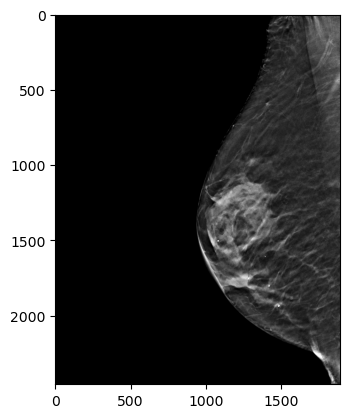

In [46]:
plt.imshow(image[20], cmap=plt.cm.gray);

In [47]:
len(image)

49

In [48]:
trainbox.head(10)
# different volume slices per exam - range? 


,PatientID,StudyUID,View,Subject,Slice,X,Y,Width,Height,Class,AD,VolumeSlices
0,DBT-P00013,DBT-S00163,rmlo,0,16,1116,1724,218,105,benign,0,49
1,DBT-P00024,DBT-S03255,lcc,0,19,267,488,64,64,benign,0,73
2,DBT-P00024,DBT-S03255,lcc,0,37,169,384,93,85,benign,0,73
3,DBT-P00024,DBT-S03255,lmlo,0,11,471,1060,67,56,benign,0,81
4,DBT-P00024,DBT-S03255,lmlo,0,12,640,673,93,80,benign,0,81
5,DBT-P00060,DBT-S00787,rcc,0,21,1276,672,228,219,benign,1,65
6,DBT-P00107,DBT-S05365,lcc,0,34,0,1148,205,449,cancer,0,66
7,DBT-P00107,DBT-S05365,lmlo,0,45,13,729,629,665,cancer,0,73
8,DBT-P00194,DBT-S00645,rmlo,0,35,1347,1730,268,255,cancer,0,80
9,DBT-P00225,DBT-S02346,lcc,0,54,266,1180,323,254,benign,1,86


In [49]:
df = read_boxes(boxes_fp = training_boxes, filepaths_fp = new_trainfile_path) 

In [50]:
box_series = df.iloc[0]
view = box_series["View"]
slice_index = box_series["Slice"]
image_path = box_series["file_path"]
# "What do the "Subject" and "Unnamed" columns mean here?"

In [51]:
%%time
image = dcmread_image(fp=image_path, view=view, index=slice_index)

/gpfs/data/huo-lab/ojomoleye/miniconda/envs/maicara/lib/python3.8/site-packages/openjpeg/utils.py:209: UserWarning: The (0028,0101) Bits Stored value '10' in the dataset does not match the component precision value '16' found in the JPEG 2000 data. It's recommended that you change the Bits Stored value to produce the correct output
  warnings.warn(


CPU times: user 11.1 s, sys: 87.6 ms, total: 11.1 s
Wall time: 11.2 s


In [52]:
x, y, width, height = box_series[["X", "Y", "Width", "Height"]]
image = draw_box(image=image, x=x, y=y, width=width, height=height, lw=10)

* How many slices per image? Can this be a column per view?
* Drawing box in 3D 
* 

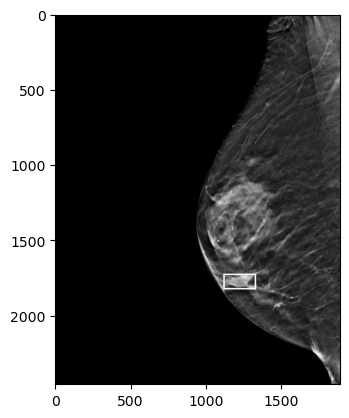

In [53]:
plt.imshow(image, cmap=plt.cm.gray);